<a href="https://colab.research.google.com/github/sooddhruv/Deepfake_Xception-Inception_resnet_v2_CNN/blob/main/Xception_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import dlib
import cv2
import os
import re
import json
from pylab import *
from PIL import Image, ImageChops, ImageEnhance
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,f1_score,classification_report
from tensorflow.keras.models import load_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
train_frame_folder = '/content/drive/MyDrive/Train'

#loading the data from json file
with open(os.path.join(train_frame_folder, 'metadata.json'), 'r') as file:
    data = json.load(file)
    
# Saving the names of videos in a list

list_of_train_data = []

for f in os.listdir(train_frame_folder):
    if f.endswith('.mp4'):
        list_of_train_data.append(f)

detector = dlib.get_frontal_face_detector()
for vid in list_of_train_data:
    count = 0
    cap = cv2.VideoCapture(os.path.join(train_frame_folder, vid))
    frameRate = cap.get(5)
    while cap.isOpened():
        frameId = cap.get(1)
        ret, frame = cap.read()
        if ret != True:
            break
        if frameId % ((int(frameRate)+1)*1) == 0:
            face_rects, scores, idx = detector.run(frame, 0)
            for i, d in enumerate(face_rects):
                x1 = d.left()
                y1 = d.top()
                x2 = d.right()
                y2 = d.bottom()
                crop_img = frame[y1:y2, x1:x2]
                # Resizing the cropped image and saving it to dataset folder in png format
                if data[vid]['label'] == 'REAL':
                    cv2.imwrite('dataset/real/'+vid.split('.')[0]+'_'+str(count)+'.png', cv2.resize(crop_img, (224, 224)))
                elif data[vid]['label'] == 'FAKE':
                    cv2.imwrite('dataset/fake/'+vid.split('.')[0]+'_'+str(count)+'.png', cv2.resize(crop_img, (224, 224)))
                count+=1

In [ ]:
input_shape = (224, 224, 3)
data_dir = 'dataset'


#Storing the real and fake image names in lists
real_data = []
fake_data = []

for f in os.listdir(data_dir+'/real'):
    if f.endswith('.png'):
        real_data.append(f)
    
for f in os.listdir(data_dir+'/fake'):
    if f.endswith('.png'):
        fake_data.append(f)    

#Creating an empty array to store the real and fake image data
X = []

#Creating an empty array store the labels
Y = []


#Appending Numpy array info of image to X and label info to Y (1 for real and 0 for fake)
for img in real_data:
    X.append(img_to_array(load_img(data_dir+'/real/'+img)).flatten() / 255.0)
    Y.append(1)
for img in fake_data:
    X.append(img_to_array(load_img(data_dir+'/fake/'+img)).flatten() / 255.0)
    Y.append(0)

Y_val_org = Y

#Normalization
X = np.array(X)
Y = to_categorical(Y, 2)

#Reshape
X = X.reshape(-1, 224, 224, 3)

#Train-Test split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.25, random_state=5)

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

googleNet_model = Xception(include_top=False, weights='imagenet', input_shape=input_shape)
googleNet_model.trainable = True
model = Sequential()
model.add(googleNet_model)
model.add(GlobalAveragePooling2D())
#model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=2, activation='softmax'))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
              metrics=['accuracy'])
model.summary()

83697664/83683744 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 20,865,578
Trainable params: 20,811,050
Non-trainable params: 54,528
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=2,
                               verbose=0, mode='auto')
EPOCHS = 10
BATCH_SIZE = 25
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data = (X_val, Y_val), verbose = 1)

Epoch 1/10
27/27 [==============================] - 73s 1s/step - loss: 0.6759 - accuracy: 0.6176 - val_loss: 0.7997 - val_accuracy: 0.2667
Epoch 2/10
27/27 [==============================] - 31s 1s/step - loss: 0.6109 - accuracy: 0.8676 - val_loss: 0.7193 - val_accuracy: 0.4489
Epoch 3/10
27/27 [==============================] - 31s 1s/step - loss: 0.5494 - accuracy: 0.8973 - val_loss: 0.6497 - val_accuracy: 0.6311
Epoch 4/10
27/27 [==============================] - 31s 1s/step - loss: 0.4888 - accuracy: 0.9271 - val_loss: 0.5704 - val_accuracy: 0.8000
Epoch 5/10
27/27 [==============================] - 31s 1s/step - loss: 0.4183 - accuracy: 0.9524 - val_loss: 0.4940 - val_accuracy: 0.8578
Epoch 6/10
27/27 [==============================] - 31s 1s/step - loss: 0.3548 - accuracy: 0.9702 - val_loss: 0.4290 - val_accuracy: 0.8756
Epoch 7/10
27/27 [==============================] - 31s 1s/step - loss: 0.2957 - accuracy: 0.9792 - val_loss: 0.3690 - val_accuracy: 0.8978
Epoch 8/10
27/27 [==

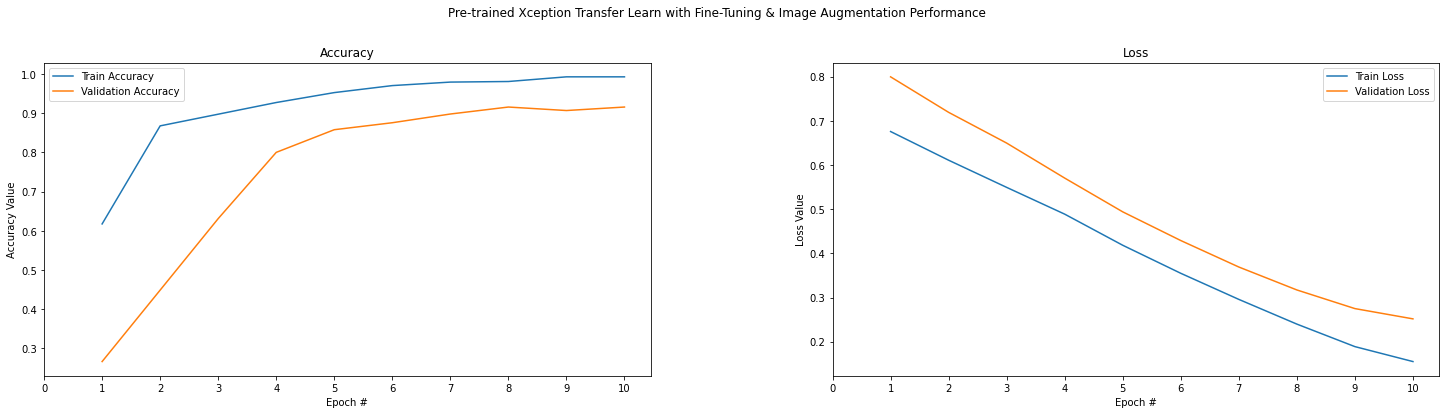

In [ ]:

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 6))
t = f.suptitle('Pre-trained Xception Transfer Learn with Fine-Tuning & Image Augmentation Performance ', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,EPOCHS+1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, EPOCHS+1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, EPOCHS+1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

True positive =  707
False positive =  5
False negative =  17
True negative =  168




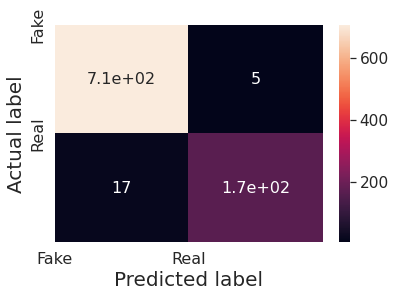

In [ ]:
#Output confusion matrix
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()
    
print_confusion_matrix(Y_val_org, np.argmax(model.predict(X),axis=-1))

In [ ]:
f1 = f1_score(Y_val_org, np.argmax(model.predict(X),axis=-1))
cr = classification_report(Y_val_org, np.argmax(model.predict(X),axis = -1))
print(f'f1 score (Xception) : {f1} \n')
print(f'Classification report : \n{cr}')

f1 score (Xception) : 0.9385474860335196 

Classification report : 
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       712
           1       0.97      0.91      0.94       185

    accuracy                           0.98       897
   macro avg       0.97      0.95      0.96       897
weighted avg       0.98      0.98      0.98       897



In [ ]:

model.save('deepfake-detection-model.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
model = load_model('deepfake-detection-model.h5')

In [ ]:
test_frame_folder = '/content/drive/MyDrive/test_videos'
list_of_test_data = [f for f in os.listdir(test_frame_folder) if f.endswith('.mp4')]
detector = dlib.get_frontal_face_detector()
with open(os.path.join(test_frame_folder, 'metadata.json'), 'r') as file:
    data_test = json.load(file)
    
actual_value = []
predicted_value = []
    
print('Video_name\tPredicted Actual')
print('-------------------------------')
    
for vid in list_of_test_data:
    count = 0
    cap = cv2.VideoCapture(os.path.join(test_frame_folder, vid))
    frameRate = cap.get(5)
    while cap.isOpened():
        frameId = cap.get(1)
        ret, frame = cap.read()
        if ret != True:
            break
        if frameId % ((int(frameRate)+1)*1) == 0:
            face_rects, scores, idx = detector.run(frame, 0)
            for i, d in enumerate(face_rects):
                x1 = d.left()
                y1 = d.top()
                x2 = d.right()
                y2 = d.bottom()
                crop_img = frame[y1:y2, x1:x2]
                data = img_to_array(cv2.resize(crop_img, (224, 224))).flatten() / 255.0
                data = data.reshape(-1, 224, 224, 3)
    actual = data_test[vid]['label']
    predicted = 'FAKE' if np.argmax(model.predict(data),axis=-1) ==[0] else 'REAL'
    print("{vid} :   {predicted}   {actual} ".format(vid = vid,predicted = predicted,actual=actual))
    
   # Storing the predictions in an array
    if np.argmax(model.predict(data),axis=-1) ==[0]:
        predicted_value.append(0)
    elif np.argmax(model.predict(data),axis=-1) ==[1]:
        predicted_value.append(1)
        
    # The label in the json file is a string so in order to get the metrics wee need to convert them to arrays
    if actual == 'FAKE':
        actual_value.append(0)
    elif actual == 'REAL':
        actual_value.append(1)

Video_name	Predicted Actual
-------------------------------
abofeumbvv.mp4 :   FAKE   FAKE 
ahqqqilsxt.mp4 :   REAL   REAL 
aapnvogymq.mp4 :   FAKE   FAKE 
abarnvbtwb.mp4 :   FAKE   REAL 
ajwpjhrbcv.mp4 :   FAKE   FAKE 
aklqzsddfl.mp4 :   FAKE   FAKE 
abqwwspghj.mp4 :   FAKE   FAKE 
aagfhgtpmv.mp4 :   FAKE   FAKE 
aipfdnwpoo.mp4 :   FAKE   FAKE 
ajqslcypsw.mp4 :   REAL   REAL 


In [ ]:
predicted_value = np.array(predicted_value)  
actual_value = np.array(actual_value)

In [ ]:
f1 = f1_score(actual_value,predicted_value)
print(f'f1 score : {f1} \n')

f1 score : 0.8 



True positive =  7
False positive =  0
False negative =  1
True negative =  2




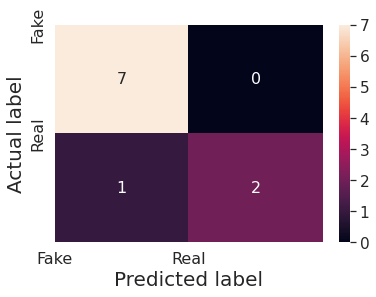

In [ ]:
print_confusion_matrix(actual_value,predicted_value)

In [ ]:
cr = classification_report(actual_value,predicted_value)
print(f'Classification report : \n{cr}')

Classification report : 
              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      0.67      0.80         3

    accuracy                           0.90        10
   macro avg       0.94      0.83      0.87        10
weighted avg       0.91      0.90      0.89        10

